In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import sys
import os
current_notebook_dir = os.getcwd()
# Replace with the path to your IT_PI.py function
project_root_dir = os.path.join(current_notebook_dir, '..', '..')
it_pi_module_dir = project_root_dir
sys.path.append(it_pi_module_dir)
import IT_PI
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering/', VIEW.as_view(), name=''),

In [2]:
df = pd.read_csv('dataset_keyhole.csv')
df.describe()
output_list = ['e*']
input_list = ['etaP', 'Vs', 'rho', 'cp', 'Tl-T0', 'r0', 'alpha']
X = np.array(df[input_list])
Y = np.array(df[output_list])
num_input = 1
variables = input_list

In [3]:
D_in = np.matrix('2  1 1  2 -3  2  0; \
                 -3 -1 0 -1  0 -2  0; \
                  1  0 0  0  1  0  0; \
                  0  0 0  0  0 -1  1')
# Rearrange D_in columns accordingly: move 3rd and 4th columns (index 2 and 3) to the end
cols = list(range(D_in.shape[1]))
new_order = cols[:2] + cols[4:7] + [2, 3] + cols[7:]  # assumes 9 columns total
D_in = D_in[:, new_order]
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows          = np.shape(D_in)[0]
num_cols          = np.shape(D_in)[1]
# Function to calculate basis matrices

# Generate basis matrices
num_basis        = D_in.shape[1] -matrix_rank(D_in)
basis_matrices   = IT_PI.calc_basis(D_in, num_basis)
print("Basis vectors:")
pprint(basis_matrices)

Rank of D_in: 4
D_in matrix:
 [[ 2  1 -3  2  0  1  2]
 [-3 -1  0 -2  0  0 -1]
 [ 1  0  1  0  0  0  0]
 [ 0  0  0 -1  1  0  0]]
Basis vectors:
matrix([[ 0. ,  2. ,  0. , -1. , -1. ,  0. ,  0. ],
        [ 0.5, -1.5, -0.5,  0. ,  0. , -1. ,  0. ],
        [ 0.5, -0.5, -0.5,  0. ,  0. ,  0. , -1. ]])


In [4]:
print(basis_matrices.shape)
print(X.shape)
print(Y.reshape(-1, 1).shape)
print(num_input)

(3, 7)
(90, 7)
(90, 1)
1


In [5]:
# Run dimensionless learning
results = IT_PI.main(
    X,
    Y.reshape(-1, 1),
    basis_matrices,
    num_input=num_input,
    estimator="kraskov",
    estimator_params={"k": 80},
    seed=42
)


input_PI = results["input_PI"]
output_PI = results["output_PI"]

epsilon  = results["irreducible_error"]
uq       = results["uncertainty"]

------------------------------------------------------------
num of parameters: 3

Using estimator: 'kraskov' with hyperparameters: {'k': 80}

(150_w,300)-aCMA-ES (mu_w=78.0,w_1=3%) in dimension 3 (seed=42, Wed Oct 29 14:25:36 2025)
[(np.float64(-0.3523000928921371), np.float64(-0.7967866239167853), np.float64(-0.24660291034507786))]
[(np.float64(0.36612089948561777), np.float64(-0.863910094118472), np.float64(-0.8639013331511427))]
[(np.float64(0.40544897085517406), np.float64(-0.1627867361131783), np.float64(-1.0286430247393803))]
[(np.float64(-0.3202079694898247), np.float64(-1.0243977915535276), np.float64(-1.0260216947078822))]
[(np.float64(-0.5306264099037761), np.float64(-1.9907943867854887), np.float64(-1.9073427533354628))]
[(np.float64(-1.0936012704686808), np.float64(-1.4089936006956374), np.float64(-0.480019534623339))]
[(np.float64(-1.3356168528648475), np.float64(-1.6886290679485276), np.float64(0.3259883372863437))]
[(np.float64(-0.858043410340575), np.float64(-0.6527294

KeyboardInterrupt: 

In [51]:
#IT_PI.plot_scatter(input_PI,output_PI)
coef_pi_list     = results["input_coef"]
optimal_pi_lab   = IT_PI.create_labels(np.array(coef_pi_list).reshape(-1, len(variables)), variables)
for j, label in enumerate(optimal_pi_lab):
    print(f'Optimal_pi_lab[{j}] = {label}')

Optimal_pi_lab[0] = $\frac{etaP^{0.66}}{Vs^{0.21} \cdot rho^{0.66} \cdot cp^{0.73} \cdot Tl-T0^{0.73} \cdot r0^{1.0} \cdot alpha^{0.33}}$


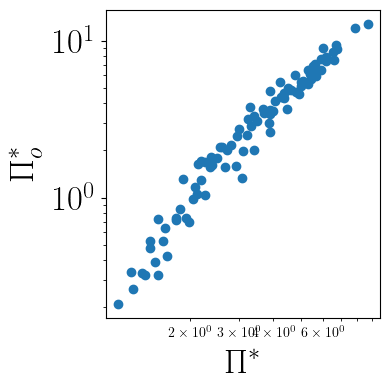

In [52]:
fig = plt.figure(figsize=(4, 4))
plt.scatter(input_PI,output_PI)
plt.xlabel(r" $\Pi^* $", fontsize=25, labelpad=8)  
plt.ylabel(r" $\Pi_{o}^*$", fontsize=25, labelpad=8)
plt.xscale("log")
plt.yscale("log")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout()
fig.savefig("keyhole.pdf", format="pdf", bbox_inches="tight",transparent = "True")

In [11]:
input_PI

array([[ 6.94460571],
       [ 8.86318552],
       [10.70743609],
       [14.05190573],
       [15.38878991],
       [ 5.11932969],
       [ 8.20996704],
       [ 9.7227344 ],
       [11.19806077],
       [14.02234299],
       [15.36704055],
       [19.07838846],
       [21.40652176],
       [23.60096347],
       [ 4.52041425],
       [ 7.34179746],
       [10.12597326],
       [12.79962265],
       [15.27033943],
       [17.73936549],
       [20.00695023],
       [22.09567231],
       [24.08122817],
       [ 6.18898686],
       [ 8.55141308],
       [10.94382635],
       [13.20154461],
       [15.49869954],
       [17.58059306],
       [19.63105051],
       [21.59293521],
       [ 7.84397368],
       [12.33313084],
       [14.42725098],
       [16.50694159],
       [18.56187488],
       [20.48180031],
       [ 7.35199862],
       [11.56740966],
       [15.70625956],
       [19.4726944 ],
       [ 4.8427438 ],
       [ 6.86839118],
       [ 8.85719684],
       [10.94451824],
       [12

In [7]:
print(f'Irreducible error (epsilon) = {epsilon}')
import pickle

workspace = {}
globals_copy = dict(globals())

for key, value in globals_copy.items():
    if not key.startswith('_') and not callable(value) and not hasattr(value, '__module__'):
        try:
            pickle.dumps(value)  # Test if it can be pickled
            workspace[key] = value
        except (TypeError, AttributeError):
            print(f"Skipping {key} - cannot pickle")

with open('output.pkl', 'wb') as f:
    pickle.dump(workspace, f)

Irreducible error (epsilon) = [0.23097639749348636]
Skipping np - cannot pickle
Skipping plt - cannot pickle
Skipping pd - cannot pickle
Skipping sys - cannot pickle
Skipping os - cannot pickle
Skipping IT_PI - cannot pickle
Skipping pickle - cannot pickle
